***
*Course:* [Math 535](http://www.math.wisc.edu/~roch/mmids/) - Mathematical Methods in Data Science (MMiDS)  
*Author:* [Sebastien Roch](http://www.math.wisc.edu/~roch/), Department of Mathematics, University of Wisconsin-Madison  
***

# <span style="background-color:dodgerblue; color:white; padding:2px 6px">APPLICATIONS</span> 
# Linear regression


*Updated:* March 20, 2020 

*Julia version:* 1.3.1

## Contents

[Recap from the lectures](#Recap-from-the-lectures)

1 [Predicting sales](#1-Predicting-sales)

2 [Understanding flight delays](#2-Understanding-flight-delays)

3 [Bootstrapping for linear regression](#3-Bootstrapping-for-linear-regression)

[Optional: using JuliaStats/GLM.jl](#Optional:-using-JuliaStats/GLM.jl)

In [1]:
using CSV, DataFrames, Plots, LinearAlgebra, Statistics

## Recap from the lectures

***The setup*** We have data of the form $\{(\mathbf{x}_i, y_i)\}_{i=1}^n$ where the $\mathbf{x}_i$'s are predictors and the $y_i$'s are outcomes. We want to estimate the relationship between the outcome variable and the predictors. This is called regression analysis. In linear regression, we assume the relationship is linear

$$
y_i = \beta_0 + \sum_{j=1}^d \beta_j x_{i,j} + \epsilon_i
$$

where $\epsilon_i$ is noise. We use the least-squares approach of finding coefficients that minimize

$$
\sum_{i=1}^n \left(y_i - \left\{\beta_0 + \sum_{j=1}^d \beta_j x_{i,j}\right\}\right)^2.
$$

We re-write it in matrix form. Let

$$
\mathbf{y} = 
\begin{pmatrix}
y_1 \\
y_2 \\
\vdots \\
y_n
\end{pmatrix},
\quad\quad
A =
\begin{pmatrix}
1 & \mathbf{x}_1^T \\
1 & \mathbf{x}_2^T \\
\vdots & \vdots \\
1 & \mathbf{x}_n^T
\end{pmatrix}
\quad\text{and}\quad
\boldsymbol{\beta} = 
\begin{pmatrix}
\beta_0 \\
\beta_1 \\
\vdots \\
\beta_d
\end{pmatrix}.
$$

Then the problem is

$$
\min_{\boldsymbol{\beta}} 
\|\mathbf{y} 
- A \boldsymbol{\beta}\|^2.
$$

***The theory*** In words, we are looking for a linear combination of the columns of $A$ that is closest to $\mathbf{y}$ in $2$-norm. 

***
**Theorem (Gram-Schmidt):** Let $\mathbf{a}_1,\ldots,\mathbf{a}_m$ be linearly independent. Then there exist an orthonormal basis $\mathbf{q}_1,\ldots,\mathbf{q}_m$ of 
$\mathrm{span}(\mathbf{a}_1,\ldots,\mathbf{a}_m)$.
***

In matrix form, let 

$$
A =
\begin{pmatrix}
| &  & | \\
\mathbf{a}_1 & \ldots & \mathbf{a}_m \\
| &  & | 
\end{pmatrix}
\quad
\text{and}
\quad
Q =
\begin{pmatrix}
| &  & | \\
\mathbf{q}_1 & \ldots & \mathbf{q}_m \\
| &  & | 
\end{pmatrix}.
$$

The output of the Gram-Schimdt algorithm above can then be written in the following compact form, known as a [QR decomposition](https://en.wikipedia.org/wiki/QR_decomposition),

$$
A = QR
$$

where column $i$ of the $m \times m$ matrix $R$ contains the coefficients of the linear combination of $\mathbf{q}_j$'s that produces $\mathbf{a}_i$. By the proof of Gram-Schmidt, 
$\mathbf{a}_i \in \mathrm{span}(\mathbf{q}_1,\ldots,\mathbf{q}_i)$. So column $i$ of $R$ has only zeros below the diagonal. Hence $R$ has a special structure: it is upper triangular.

**Definition (Orthogonal projection):** Let $U \subseteq V$ be a linear subspace with orthonormal basis $\mathbf{q}_1,\ldots,\mathbf{q}_m$. The orthogonal projection of $\mathbf{v} \in V$ on $U$ is defined as

$$
\mathcal{P}_U \mathbf{v}
= \sum_{j=1}^m \langle \mathbf{v}, \mathbf{q}_j \rangle \,\mathbf{q}_j.
$$

$\lhd$

***
**Theorem (Orthogonal Projection is Closest in Subspace):** Let $U \subseteq V$ be a linear subspace with orthonormal basis $\mathbf{q}_1,\ldots,\mathbf{q}_m$ and let $\mathbf{v} \in V$. For any $\mathbf{u} \in U$

$$
\|\mathbf{v} - \mathcal{P}_U \mathbf{v}\| \leq \|\mathbf{v} - \mathbf{u}\|.
$$

Furthermore, if $\mathbf{u} \in U$ and the inequality above is an equality, then $\mathbf{u} = \mathcal{P}_U  \mathbf{v}$.
***

From this results we get:

***
**Theorem (Least Squares via QR):** Let $A \in \mathbb{R}^{n\times m}$ be an $n\times m$ matrix with linearly independent columns, let $\mathbf{b} \in \mathbb{R}^n$ be a vector,
and let $A = QR$ be a QR decomposition of $A$. The solution to the least-squares problem

$$
\min_{\mathbf{x} \in \mathbb{R}^m} \|A \mathbf{x} - \mathbf{b}\|.
$$

satisfies

$$
R \mathbf{x}^* = Q^T \mathbf{b}. 
$$

***

***The algorithm*** 

In [2]:
function mmids_gramschmidt(A)
    n, m = size(A)
    Q = zeros(Float64, n, m)
    R = zeros(Float64, m, m)
    for j = 1:m
        v = A[:,j]
        for k = 1:j-1
            R[k,j] = dot(Q[:,k],A[:,j])
            v -= R[k,j]*Q[:,k]
        end
        R[j,j] = norm(v)
        Q[:,j] = v/R[j,j]
    end
    return Q, R
end

mmids_gramschmidt (generic function with 1 method)

In [3]:
function mmids_backsubs(R,z)
    m = length(z)
    x = zeros(Float64,m)
    for i=m:-1:1
        x[i] = (z[i] - dot(R[i,i+1:m],x[i+1:m]))/R[i,i]
    end
    return x
end

mmids_backsubs (generic function with 1 method)

In [4]:
function mmids_linreg(A,y)
    Q,R = mmids_gramschmidt(A)
    return coeff = mmids_backsubs(R,Q'*y)
end

mmids_linreg (generic function with 1 method)

## 1 Predicting sales

The following dataset is from [[ISLR]](http://faculty.marshall.usc.edu/gareth-james/ISL/) textbook. Quoting [ISLR, Section 2.1]:

> Suppose that we are statistical consultants hired by a client to provide advice on how to improve sales of a particular product. The `Advertising` data set consists of the `sales` of that product in 200 different markets, along with advertising budgets for the product in each of those markets for three different media: `TV`, `radio`, and `newspaper`. [...] It is not possible for our client to directly increase sales of the product. On the other hand, they can control the advertising expenditure in each of the three media. Therefore, if we determine that there is an association between advertising and sales, then we can instruct our client to adjust advertising budgets, thereby indirectly increasing sales. In other words, our goal is to develop an accurate model that can be used to predict sales on the basis of the three media budgets.

In [5]:
df = CSV.read("./advertising.csv")
first(df,5)

,TV,radio,newspaper,sales
,Float64,Float64,Float64,Float64
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


We will focus for now on the TV budget.

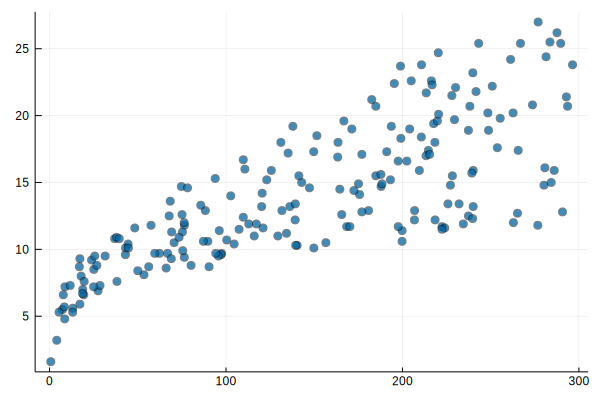

In [6]:
TV, sales = df[:,:TV], df[:,:sales]
scatter(TV, sales, legend=false, alpha=0.5)

We form the matrix $A$ and use our least-squares code to solve for $\boldsymbol{\beta}$. 

In [7]:
n = length(sales)
A = hcat(ones(n), TV)
coeff = mmids_linreg(A,sales)

2-element Array{Float64,1}:
 7.032593549127698   
 0.047536640433019715

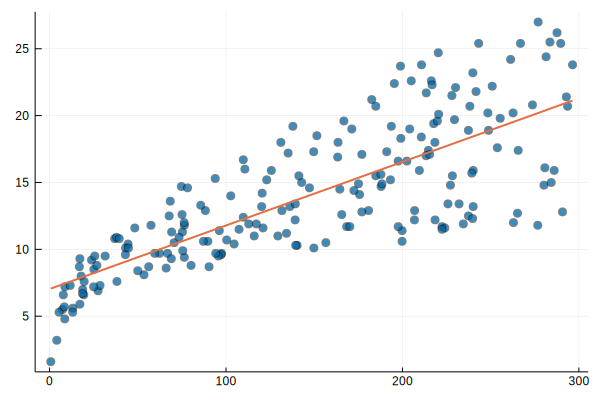

In [8]:
TVgrid = LinRange(minimum(TV), maximum(TV), 100)
scatter(TV, sales, legend=false, alpha=0.5)
plot!(TVgrid, coeff[1].+coeff[2]*TVgrid, lw=2) # recall that array indices start at 1

A degree-two polynomial might be a better fit.

In [9]:
A = reduce(hcat, [ones(n), TV, TV.^2])
coeff = mmids_linreg(A, sales)

3-element Array{Float64,1}:
  6.114120128333173   
  0.06726592695624341 
 -6.846933732938574e-5

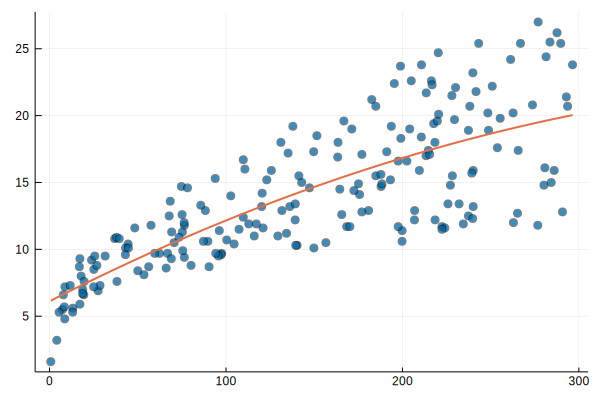

In [10]:
scatter(TV, sales, legend=false, alpha=0.5)
plot!(TVgrid, coeff[1] .+ coeff[2]*TVgrid .+ coeff[3]*TVgrid.^2, lw=2)

The fit looks slightly better than the linear one. This is not entirely surprising though given that the linear model is a subset of the quadratic one. But, in adding more parameters, one must worry about [overfitting](https://en.wikipedia.org/wiki/Overfitting#cite_note-1). To quote Wikipedia:

>In statistics, overfitting is "the production of an analysis that corresponds too closely or exactly to a particular set of data, and may therefore fail to fit additional data or predict future observations reliably".[[1](https://en.wikipedia.org/wiki/Overfitting#cite_note-1)] An overfitted model is a statistical model that contains more parameters than can be justified by the data.[[2](https://en.wikipedia.org/wiki/Overfitting#cite_note-CDS-2)] The essence of overfitting is to have unknowingly extracted some of the residual variation (i.e. the noise) as if that variation represented underlying model structure.[[3](https://en.wikipedia.org/wiki/Overfitting#cite_note-BA2002-3)]

To illustrate, let's see what happens with a degree-$20$ polynomial fit.

In [11]:
deg = 20
A = reduce(hcat, [TV.^i for i=0:1:deg])
coeff = mmids_linreg(A,sales)

21-element Array{Float64,1}:
 -3.5585977540902536    
  2.0021336847590248    
 -0.1233189885590326    
  0.0036085607135777384 
 -5.6478529614305553e-5 
  5.066584217206096e-7  
 -2.636811499752899e-9  
  7.448712912490157e-12 
 -8.069845629867099e-15 
 -8.44032625003494e-18  
  2.399545651190107e-20 
 -6.4163980256846685e-24
 -2.76751130720257e-27  
 -2.4155350596509822e-30
 -2.918570551603851e-33 
 -4.306170305771181e-36 
 -7.291913511528186e-39 
 -1.3665252191757837e-41
 -2.768224810671247e-44 
 -5.964198348318315e-47 
 -1.3508089378473585e-49

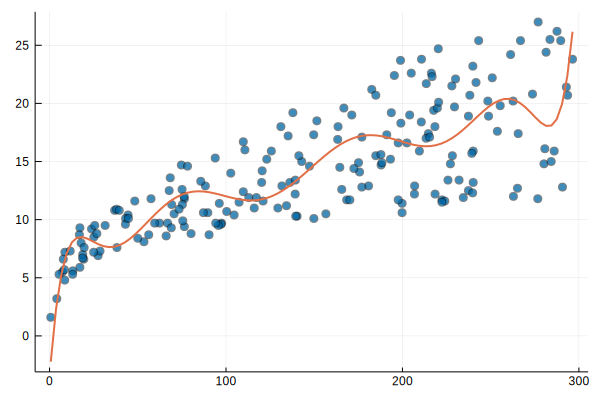

In [12]:
saleshat = reduce(+,[coeff[i+1]*TVgrid.^i for i=0:1:deg])
scatter(TV, sales, legend=false, alpha=0.5)
plot!(TVgrid, saleshat, lw=2)

We could use [cross-validation](https://www.textbook.ds100.org/ch/15/bias_cv.html) to choose a suitable degree.

We return to the linear case, but with the full set of predictors.

In [13]:
radio, newspaper = df[:,:radio], df[:,:newspaper];

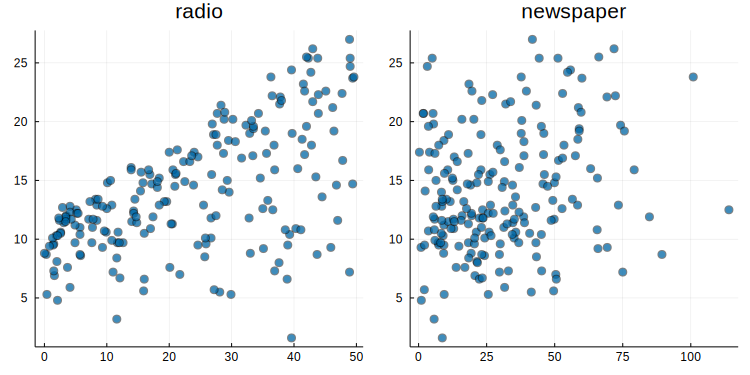

In [14]:
p1 = scatter(radio, sales, legend=false, alpha=0.5, title="radio")
p2 = scatter(newspaper, sales, legend=false, alpha=0.5, title="newspaper")
plot(p1, p2, laytout=(2,1), size=(750,375))

In [15]:
A = reduce(hcat, [ones(n), TV, radio, newspaper])
coeff = mmids_linreg(A, sales)

4-element Array{Float64,1}:
  2.9388893694594307   
  0.04576464545539755  
  0.18853001691820379  
 -0.0010374930424762435

Newspaper advertising (the last coefficient) seems to have a much weaker effect on sales per dollar spent. We will come back later in the course to assessing the [statistical significance](https://en.wikipedia.org/wiki/Statistical_significance) of such a conclusion.

## 2 Analyzing flight delays

Suppose we are interested in gaining a better understanding of flight delays. Let's get some data from the DOT's [Bureau of Transportation Statistics](https://www.transtats.bts.gov/DL_SelectFields.asp). The following dataset contains information about every flight out of Madison, WI between December 1, 2018 and November 30, 2019 (that were not cancelled or diverted). This information includes the date (`date`), day of week (`day_of_week`; `1` is Monday, `2` is Tuesday and so on), carrier (`carrier`), flight number (`fl_num`), destination (`dest`), scheduled departure time (`sch_dep`; e.g. `20.5` is 8:30pm), scheduled arrival time (`sch_arr`), and arrival delay (`arr_delay`; e.g. `-33.0` means the flight arrived 33 minutes early). 

In [16]:
df = CSV.read("./msn-flight-data-19.csv")
first(df, 5)

,date,day_of_week,carrier,fl_num,dest,sch_dep,sch_arr,arr_delay
,Dates…,Int64,String,Int64,String,Float64,Float64,Float64
1,2018-12-10,1,DL,949,DTW,13.6667,16.1,-33.0
2,2018-12-10,1,DL,1223,ATL,17.2667,20.4833,-16.0
3,2018-12-10,1,DL,1386,MSP,6.41667,7.78333,-21.0
4,2018-12-10,1,DL,1495,DTW,6.58333,9.1,-27.0
5,2018-12-10,1,DL,1547,MSP,17.3333,18.6333,72.0


In [17]:
describe(df)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Nothing,DataType
1,date,,2018-12-01,,2019-11-30,365,,Date
2,day_of_week,3.90154,1,4.0,7,,,Int64
3,carrier,,9E,,YX,11,,String
4,fl_num,3515.57,159,3651.0,6117,,,Int64
5,dest,,ATL,,SLC,26,,String
6,sch_dep,12.7728,5.08333,13.3167,21.9,,,Float64
7,sch_arr,14.9175,6.23333,15.7833,23.9833,,,Float64
8,arr_delay,6.59901,-61.0,-8.0,1540.0,,,Float64


Let's say we suspect that the average delay gets worse throughout the day. By using linear regression, we can try to quantify the relationship between scheduled departure times and arrival delays. Let's extract the relevant columns first.

In [18]:
sch_dep = df[:,:sch_dep];
arr_delay = df[:,:arr_delay];
n = nrow(df)

13579

The average delay in minutes was:

In [19]:
mean(arr_delay)

6.5990131821194495

Here is an histogram of arrival delays (truncated at 4 hours).

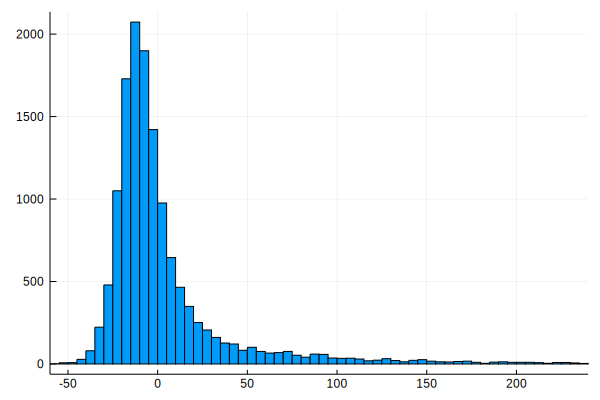

In [20]:
histogram(arr_delay, legend=false, nbins=300, xlims=(-60,240))

To get a sense of the relationship between scheduled departure times and arrival delays, we use a scatter plot. (This is a rather large dataset. To avoid making the notebook too sluggish, we only plot a random samples of $1000$ flights.)

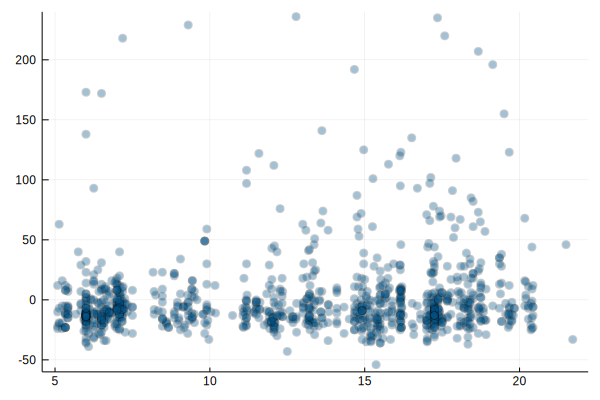

In [21]:
subsample = rand(1:n,1000);
scatter(sch_dep[subsample], arr_delay[subsample], 
    legend=false, alpha=0.2, ylims=(-60,240))

Finally, we form the matrix $A$ and use our linear regression algorithm.

In [22]:
A = reduce(hcat, [ones(n), sch_dep])
beta = mmids_linreg(A, arr_delay)

2-element Array{Float64,1}:
 -3.906848102051206 
  0.8225205619598671

So this suggest that delays increase by roughly $0.8$ minutes per hour. Over $17$-hour day, that adds up to about $14$ minutes by the end of the day.

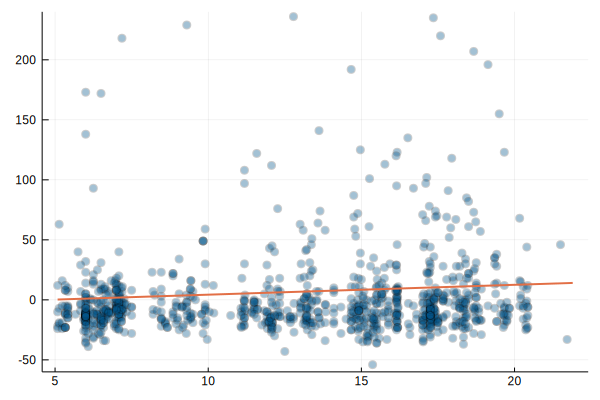

In [23]:
x = LinRange(minimum(sch_dep), maximum(sch_dep), 100)
y = beta[1] .+ beta[2]*x;
scatter(sch_dep[subsample], arr_delay[subsample], 
    legend=false, alpha=0.2, ylims=(-60,240))
plot!(x, y, lw=2)

We may suspect that other factors have a greater impact on delays, for instance, the destination. Let's look at O'Hare. The average delay when going from Madison to O'Hare is:

In [24]:
dest = df[:,:dest]
mean(arr_delay[findall(x -> x == "ORD", dest)])

12.519916868721857

To [account for the effect of the time of day](https://en.wikipedia.org/wiki/Controlling_for_a_variable) (perhaps flights to ORD tend to be later), we perform a multiple linear regression with both `sch_dep` and whether or not the destination is ORD. How do we encode the latter in a numerical value? We use [dummy coding](https://en.wikipedia.org/wiki/Categorical_variable#Dummy_coding). That is, we introduce a new variable which is $1$ if a flight is headed to ORD and $0$ otherwise.

In [25]:
to_ord = Float64.(dest .== "ORD");

We then add `to_ord` to our $A$ matrix and perform multiple linear regression. 

In [26]:
A = reduce(hcat, [ones(n), sch_dep, to_ord])
beta = mmids_linreg(A, arr_delay)

3-element Array{Float64,1}:
 -5.331027103829657 
  0.8114827228893294
  7.361740408240525 

So going to ORD adds roughly $7$ minutes to the baseline of all other flights.

*Exercise:* Suppose that we add two extra columns: one which encodes "going to MSP", that is, it is $0$ if a flight is going to MSP and $1$ otherwise; one which encodes every other flight, that is, it is $1$ if the flight is going to neither ORD or MSP, and $0$ otherwise.

In [27]:
to_msp = Float64.(dest .== "MSP")
to_others = Float64.((dest .!= "ORD") .& (dest .!= "MSP"))
A = reduce(hcat, [ones(n), sch_dep, to_ord, to_msp, to_others])
beta = mmids_linreg(A, arr_delay)

5-element Array{Float64,1}:
  1.008890516131248e15 
  1.9055717586217782   
 -1.0088905161312581e15
 -1.008890516131269e15 
 -1.0088905161312655e15

What happened? Which assumption is not satisfied in this case? Check your answer numerically. Find the right solution by modifying the matrix $A$. $\lhd$

## 3 Bootstrapping for linear regression

Our coefficients are estimated from a sample. There is intrinsic variability in our sampling procedure. We would like to understand how our estimated coefficients compare to the true coefficients. This is set up beautifully in [[Data8](https://www.inferentialthinking.com/chapters/13/2/Bootstrap.html), Section 13.2]:

> A data scientist is using the data in a random sample to estimate an unknown parameter. She uses the sample to calculate the value of a statistic that she will use as her estimate. Once she has calculated the observed value of her statistic, she could just present it as her estimate and go on her merry way. But she's a data scientist. She knows that her random sample is just one of numerous possible random samples, and thus her estimate is just one of numerous plausible estimates. By how much could those estimates vary? To answer this, it appears as though she needs to draw another sample from the population, and compute a new estimate based on the new sample. But she doesn't have the resources to go back to the population and draw another sample. It looks as though the data scientist is stuck. Fortunately, a brilliant idea called *the bootstrap* can help her out. Since it is not feasible to generate new samples from the population, the bootstrap generates new random samples by a method called *resampling*: the new samples are drawn at random *from the original sample*.

Without going into much detail (see [[DS100](https://www.textbook.ds100.org/ch/18/hyp_regression.html), Section 18.3] for more), it works as follows. Let $\{(\mathbf{x}_i, y_i)\}_{i=1}^n$ be our data. We assume that our sample is representative of the population and we simulate our sampling procedure by resampling from the sample. That is, we take a random sample with replacement $\mathcal{X}_{\mathrm{boot},1} = \{(\mathbf{x}_i, y_i)\,:\,i \in I\}$ where $I$ is a [multi-set](https://en.wikipedia.org/wiki/Multiset) of elements from $[n]$ of size $n$. We recompute our estimated coefficients on $\mathcal{X}_{\mathrm{boot},1}$. Then we repeat independently for a desired number of replicates $\mathcal{X}_{\mathrm{boot},1}, \ldots, \mathcal{X}_{\mathrm{boot},r}$. Plotting a histogram of the resulting coefficients gives some idea of the variability of our estimates.

We implement the bootstrap for linear regression in Julia next.

In [28]:
function mmids_linregboot(A,b;replicates=10000)
    n,m = size(A)
    coeff_boot = zeros(Float64,m,replicates)
    for i =1:replicates
        resample = rand(1:n,n)
        Aboot = A[resample,:]
        bboot = b[resample]
        coeff_boot[:,i] = mmids_linreg(Aboot,bboot)
    end
    return coeff_boot
end

mmids_linregboot (generic function with 1 method)

First, let's use a simple example from the lecture with a known ground truth. 

In [29]:
n, b0, b1 = 1000, -1, 1
x = LinRange(0,10,n)
y = b0 .+ b1*x .+ randn(n)
A = hcat(ones(n),x);

The estimated coefficients are the following.

In [30]:
mmids_linreg(A,y)

2-element Array{Float64,1}:
 -0.8571891676663859
  0.9853671402330382

Now we apply the bootstrap and plot histograms of the two coefficients.

In [31]:
coeff_boot = mmids_linregboot(A,y);

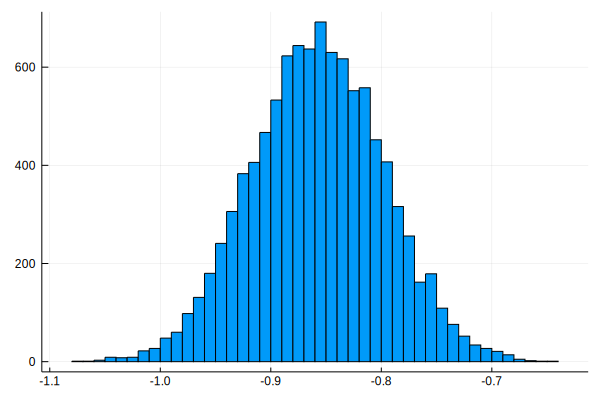

In [32]:
histogram(coeff_boot[1,:], legend=false)

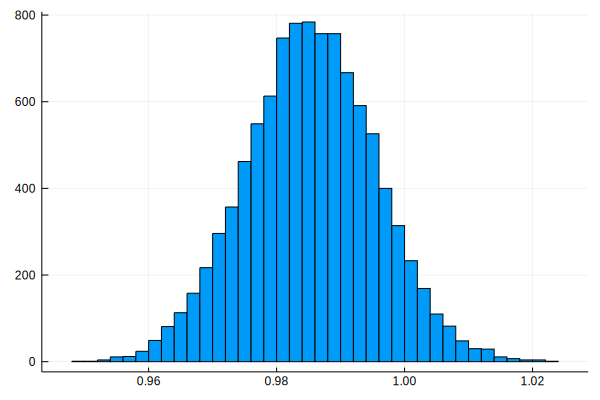

In [33]:
histogram(coeff_boot[2,:], legend=false)

We see in the histograms that the true coefficient values $-1$ and $1$ fall within the likely range. 

We return to the `Advertising` dataset and apply the bootstrap.

In [34]:
n = length(sales)
A = reduce(hcat, [ones(n), TV, radio, newspaper])
mmids_linreg(A,sales)

4-element Array{Float64,1}:
  2.9388893694594307   
  0.04576464545539755  
  0.18853001691820379  
 -0.0010374930424762435

In [35]:
coeff_boot = mmids_linregboot(A,sales);

Plotting a histogram of the coefficients corresponding to newspaper advertising shows that $0$ is a plausible value, while it is not for TV advertising.

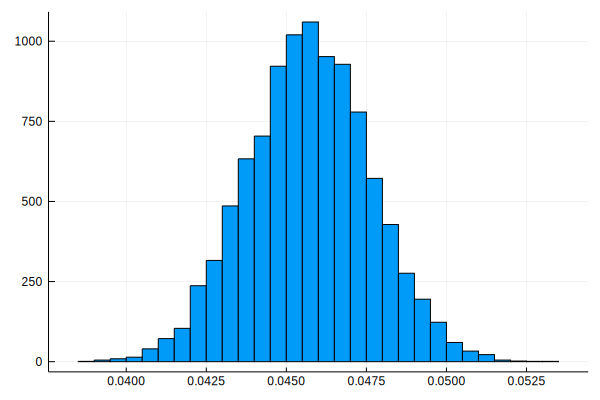

In [36]:
histogram(coeff_boot[2,:], legend=false)

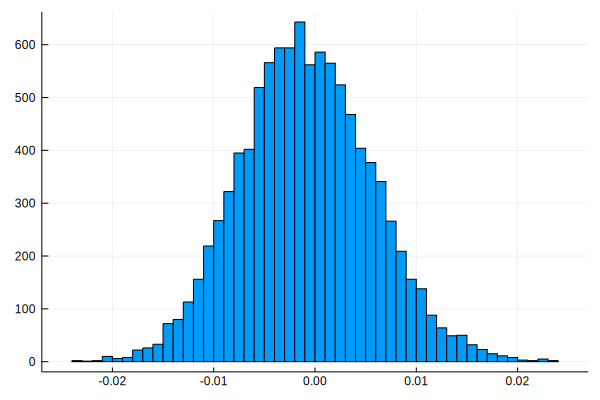

In [37]:
histogram(coeff_boot[4,:], legend=false)

## Optional: using JuliaStats/GLM.jl

We can use the GML.jl package to perform linear regression. Let's look at the `Advertising` dataset again.

In [38]:
df = DataFrame(CSV.File("./advertising.csv"));

To use the GLM package we first load it. (Make sure to have installed it first.)

In [39]:
using GLM

We then use the [`lm`](https://juliastats.org/GLM.jl/v0.11/index.html#Minimal-examples-1) function. It uses a special syntax to define the linear model. Specifically, `@formula(sales ~ TV + radio + newspaper)` means that our output is `sales`, that our predictors are `TV`, `radio` and `newspaper`, and that we seek an affine relationship between them (the intercept being implicit).

In [40]:
model = lm(@formula(sales ~ TV + radio + newspaper), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

sales ~ 1 + TV + radio + newspaper

Coefficients:
────────────────────────────────────────────────────────────────────────────────
                Estimate  Std. Error    t value  Pr(>|t|)   Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────────
(Intercept)   2.93889     0.311908     9.42229     <1e-16   2.32376    3.55402  
TV            0.0457646   0.0013949   32.8086      <1e-80   0.0430137  0.0485156
radio         0.18853     0.00861123  21.8935      <1e-53   0.171547   0.205513 
newspaper    -0.00103749  0.00587101  -0.176715    0.8599  -0.012616   0.010541 
────────────────────────────────────────────────────────────────────────────────

The column `Estimate` gives the coefficients. This is the same answer we got with our implementation. We will come back to what the other columns mean later in the course.

We can extract the coefficients using the function `coef`.

In [41]:
coef(model)

4-element Array{Float64,1}:
  2.9388893694594067   
  0.04576464545539758  
  0.1885300169182034   
 -0.0010374930424754524